# Истинная орбита МКС - фильтр Калмана

## Импорт Необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Функции

In [2]:
def FuncOrbite(t, x): # Функция f(x, t)
    r = np.copy(x[:3])
    r_abs = np.linalg.norm(r)
    v = np.copy(x[3:])
    second_order = (np.array([r[0]*r[2]**2, r[1]*r[2]**2, r[2]**3]) * 15 / r_abs**7 -
                    np.array([3*r[0], 3*r[1], 9*r[2]]) / r_abs**5) * mu * J2 * R**2 / 2 
    return np.concatenate((v, -mu * r / r_abs**3 + second_order), axis=0)

def FuncMeasure(x): # Функция h(x)
    return x

def ModelError(t): # Функция шума модели состояния. Функция может быть любой, но ограниченной
    rng = np.random.default_rng()
    return Ampl_w * rng.random(6)

def MeasureError(t): # Функция шума модели наблюдения. Функция может быть любой, но ограниченной
    rng = np.random.default_rng()
    return Ampl_v * rng.random(6)

def GessianF(x):
    r = np.copy(x[:3])
    r_abs = np.linalg.norm(r)
    Phi = np.zeros((6,6))
    Phi[3:6, 0:3] = np.eye(3)
    a = mu * J2 * R**2 / 2 * (15 * r[2]**2 / r_abs**7 - 3 / r_abs**5)
    b = 15 * mu * J2 * R**2 / r_abs**7 * r[2]
    Phi[4:0] = -mu / r_abs**3 + a
    Phi[5:1] = -mu / r_abs**3 + a
    Phi[6:2] = -mu / r_abs**3 + 3*a
    Phi[4:2] = b * r[0]
    Phi[5:2] = b * r[1]
    return Phi

def GessianH(x):
    return np.eye(6)

def time(str_t):
    A = str_t.split(':')
    for i in range(len(A)):
        if A[i][0:2] == '00':
            if len(A[i]) <= 2:
                A[i] = '0'
            else:
                A[i] = '0' + A[i][2:]
    return int(A[0]) * 3600 + int(A[1]) * 60 + float(A[2])

## Расширенный фильтр Калмана

### Предиктор

In [3]:
def predictorStatus(xk_1, tk_1, tk):
    dt = tk - tk_1
    xk_estimated = xk_1 + FuncOrbite(tk, xk_1) * dt
    return xk_estimated

def predictorCovar(Pk_1, xk_1, tk_1, tk):
    dt = tk - tk_1
    Phi = np.eye(6) + GessianF(xk_1) * dt
    wk = ModelError(tk_1)
    Q = np.outer(wk, wk) # Матрица ковариаций шумов модели
    Pk_estimated = Phi @ Pk_1 @ Phi.T + Q
    return Pk_estimated

### Корректор

In [4]:
def MatrixK(Pk_estimated, xk_estimated, tk):
    vk = MeasureError(tk)
    R = np.outer(vk, vk) # Матрица ковариаций шумов модели
    H = GessianH(xk_estimated)
    K = Pk_estimated @ H.T @ np.linalg.inv(H @ Pk_estimated @ H.T + R)
    return K

def correctorStatus(xk_estimated, zk, K):
    xk = xk_estimated + K @ (zk - FuncMeasure(xk_estimated))
    return xk

def correctorCovar(Pk_estimated, xk, K):
    Pk = (np.eye(6) - K @ GessianH(xk)) @ Pk_estimated
    return Pk

## Параметры

In [26]:
mu = 3.986004418e5
J2 = 0.0010827 * 0
R = 6378.137

# Параметры для w(t):
Ampl_w = 1

# Параметры для v(t):
Ampl_v = 1

## Рабочая область

In [29]:
data = pd.read_csv("iss_test.txt", delim_whitespace=True)
x = np.array(data.iloc[0, 1:])
P = np.diag([10, 10, 10, 0.01, 0.01, 0.01])
status = data.copy(deep=True)
for i in range(1, data.shape[0]):
    t_curr = time(data.iloc[i, 0])
    t_prev = time(data.iloc[i-1, 0])
    x_est = predictorStatus(x, t_prev, t_curr)
    #P_est = predictorCovar(P, x, t_prev, t_curr)
    #K = MatrixK(P_est, x_est, t_curr)
    #z = np.array(data.iloc[i, 1:])
    #x = correctorStatus(x_est, z, K)
    #P = correctorCovar(P_est, x, K)
    status.iloc[i, 1:] = x_est
    #print("x_est = ", x_est)
    #print("z = ", z)
    #print("x = ", x)
    #print("=======")

## Отображение результатов:

1  Jan  2000    0.00000
        2000    4.71364
        2000    4.71364
        2000    4.71364
        2000    4.71364
                 ...   
        2000    4.71364
        2000    4.71364
        2000    4.71364
        2000    4.71364
        2000    4.71364
Name: DefaultSC.EarthMJ2000Eq.Y, Length: 6001, dtype: float64


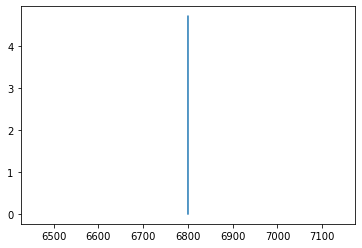

In [32]:
print(status.iloc[:, 2])
plt.plot(status.iloc[:, 1], status.iloc[:, 2])
plt.show()